# Imports

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import numpy as np
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

from datasets import load_dataset
import joblib


In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset

In [3]:
def prepare_and_load_dataset(embed_type, seed):
    
    dataset = load_dataset("Paulozs/WELFake_embeddings")
    print(dataset)

    df = dataset["train"].to_pandas()
    display(df)

    y = df["label"]
    x = df[embed_type]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    print(x_train, y_train)
    print(x_train.shape)
    print(x_train[0].shape)

    x_train_fixed = np.stack(x_train)  
    x_test_fixed = np.stack(x_test)

    print(x_train_fixed.shape)  
    print(x_test_fixed.shape)

    return x_train, x_train_fixed, x_test_fixed, y_train, y_test


# Model

In [4]:
def knn_model(x_train_fixed, y_train, k=5):

    print("Training baseline KNN model...")
    knn = KNeighborsClassifier(k)
    knn.fit(x_train_fixed, y_train)

    return knn

# Hyperparameter Training + Cross Validation

In [5]:

def hyperparamter_tuning(seed, x_train_fixed, x_test_fixed, y_train, y_test, model):
    param_dist = {
    'n_neighbors': randint(1, 30),  
    'weights': ['uniform', 'distance'], 
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

    rand_search = RandomizedSearchCV(model, 
                                    param_distributions = param_dist, 
                                    n_iter=20, 
                                    cv=5,
                                    n_jobs=-1,
                                    random_state=seed)

    rand_search.fit(x_train_fixed, y_train)

    # Create a variable for the best model
    best_model = rand_search.best_estimator_
    print('Best hyperparameters:',  rand_search.best_params_)

    # Generate predictions with the best model
    y_pred = best_model.predict(x_test_fixed)

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot();

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    return best_model, accuracy, precision, recall


# Results on Train-Test Split

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


60658    [0.40477852074583215, -0.09409811390822732, 0....
31060    [0.25348652649285985, 0.009226837375450297, 0....
33930    [0.2927856570282637, -0.09988830952040968, -0....
32661    [0.4845020605784105, 0.3699292930013124, -0.13...
59657    [0.4018736563583435, 0.04977131805575994, -0.2...
                               ...                        
62570    [0.3077755853311347, 0.05343261234196366, 0.11...
38158    [0.3364898683291863, -0.15858749358854204, 0.0...
860      [0.3806204018661383, 0.06499511359072946, 0.39...
15795    [0.15963267694661168, -0.05656247974960259, 0....
56422    [0.44664347831546597, -0.055909660383521964, 0...
Name: tfidf_embedding, Length: 50073, dtype: object 60658    1
31060    1
33930    0
32661    1
59657    0
        ..
62570    1
38158    1
860      1
15795    1
56422    0
Name: label, Length: 50073, dtype: int64
(50073,)
(300,)
(50073, 300)
(12519, 300)
Training baseline KNN model...
Best hyperparameters: {'n_neighbors': 7, 'p': 2, 'weights': 'uni

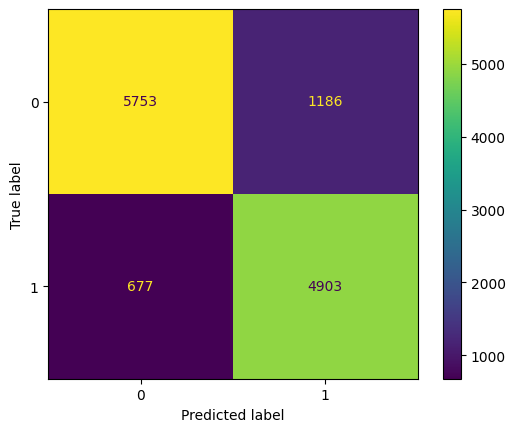

In [6]:
embed_type = "tfidf_embedding"
seed = 42

x_train, x_train_fixed, x_test_fixed, y_train, y_test = prepare_and_load_dataset(embed_type, seed)
model = knn_model(x_train_fixed, y_train, k=5)
tfidf_best_model , accuracy, precision, recall = hyperparamter_tuning(seed, x_train_fixed, x_test_fixed, y_train, y_test, model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")


DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


60658    [12.24737165975087, -4.796334804708539, -6.915...
31060    [3.293731435032349, -1.0580339257027993, -2.53...
33930    [6.38297736641625, -2.794863583301979, -1.4855...
32661    [16.533978581116404, 14.66220624250616, -2.171...
59657    [7.942604424717171, 2.3166336267766385, -1.265...
                               ...                        
62570    [5.256297562158277, -0.40019993684586075, -3.3...
38158    [10.290112204015795, -4.888459331289131, 8.078...
860      [13.101648421620542, 0.16652926226071058, -7.8...
15795    [1.3404478220184168, -0.8902983393138241, -1.1...
56422    [9.232007602233484, -2.2358124767177023, -3.33...
Name: bow_embedding, Length: 50073, dtype: object 60658    1
31060    1
33930    0
32661    1
59657    0
        ..
62570    1
38158    1
860      1
15795    1
56422    0
Name: label, Length: 50073, dtype: int64
(50073,)
(300,)
(50073, 300)
(12519, 300)
Training baseline KNN model...
Best hyperparameters: {'n_neighbors': 10, 'p': 2, 'weights': 'dist

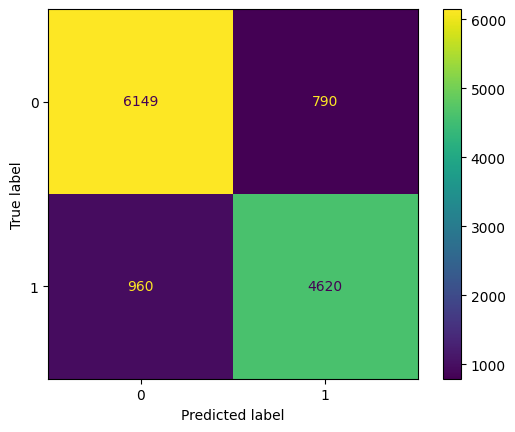

In [7]:
embed_type = "bow_embedding"
seed = 42

x_train, x_train_fixed, x_test_fixed, y_train, y_test = prepare_and_load_dataset(embed_type, seed)
model = knn_model(x_train_fixed, y_train, k=5)
bow_best_model, accuracy, precision, recall = hyperparamter_tuning(seed, x_train_fixed, x_test_fixed, y_train, y_test, model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


60658    [0.5810164, -0.52850246, -0.008906364, -0.2958...
31060    [0.6990385, -0.77093554, 0.33750772, -0.351861...
33930    [0.44385824, 0.19419289, -0.72304606, -0.29523...
32661    [0.676581, -1.0765883, -0.25527573, -0.1949930...
59657    [0.89001536, 0.72814655, -0.21356225, -0.15115...
                               ...                        
62570    [0.7161679, -0.06557679, -0.08170533, 0.073140...
38158    [0.7637837, -0.029256701, -0.3262794, -0.39502...
860      [0.703634, 0.056003213, -0.33440924, 0.1529498...
15795    [0.6035794, -0.352242, 1.2075305, -0.16041708,...
56422    [0.47580132, -0.028593779, -0.47311783, 0.1854...
Name: roberta_embedding, Length: 50073, dtype: object 60658    1
31060    1
33930    0
32661    1
59657    0
        ..
62570    1
38158    1
860      1
15795    1
56422    0
Name: label, Length: 50073, dtype: int64
(50073,)
(300,)
(50073, 300)
(12519, 300)
Training baseline KNN model...
Best hyperparameters: {'n_neighbors': 10, 'p': 2, 'weights': '

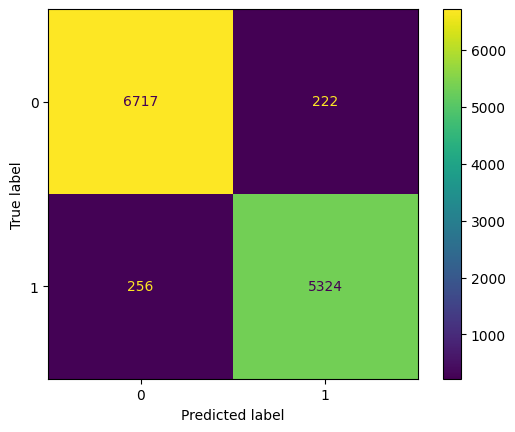

In [8]:
embed_type = "roberta_embedding"
seed = 42

x_train, x_train_fixed, x_test_fixed, y_train, y_test = prepare_and_load_dataset(embed_type, seed)
model = knn_model(x_train_fixed, y_train, k=5)
roberta_best_model , accuracy, precision, recall = hyperparamter_tuning(seed, x_train_fixed, x_test_fixed, y_train, y_test, model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


60658    [0.032806076, 0.05030123, 0.037030075, 0.08091...
31060    [0.030869182, 0.04790664, 0.046489246, 0.05830...
33930    [-0.014758263, 0.0526478, 0.028966146, 0.12925...
32661    [-0.012748449, 0.060338553, -0.012492027, 0.11...
59657    [-0.0062476927, 0.029795578, -0.002672, 0.0448...
                               ...                        
62570    [0.009170532, 0.05493455, -0.004049059, 0.0367...
38158    [0.0014468685, 0.055714957, 0.015201344, 0.111...
860      [-0.0043011224, 0.035326872, 0.01682995, 0.019...
15795    [0.0061974158, 0.053823683, -0.016401079, 0.08...
56422    [-0.008613925, 0.059554663, 0.03064818, 0.0775...
Name: w2v_embedding, Length: 50073, dtype: object 60658    1
31060    1
33930    0
32661    1
59657    0
        ..
62570    1
38158    1
860      1
15795    1
56422    0
Name: label, Length: 50073, dtype: int64
(50073,)
(300,)
(50073, 300)
(12519, 300)
Training baseline KNN model...
Best hyperparameters: {'n_neighbors': 12, 'p': 1, 'weights': 'dist

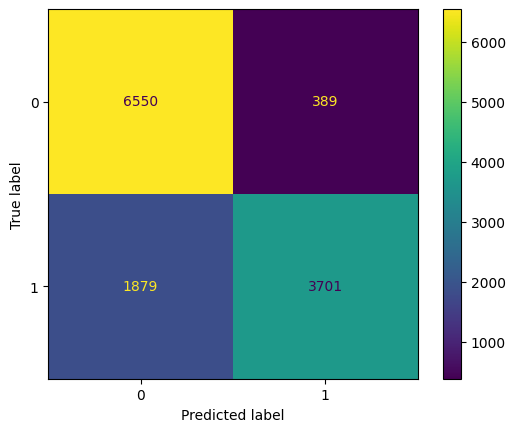

In [9]:
embed_type = "w2v_embedding"
seed = 42

x_train, x_train_fixed, x_test_fixed, y_train, y_test = prepare_and_load_dataset(embed_type, seed)
model = knn_model(x_train_fixed, y_train, k=5)
w2v_best_model, accuracy, precision, recall = hyperparamter_tuning(seed, x_train_fixed, x_test_fixed, y_train, y_test,model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

# Result on Test Set

In [11]:
def test(embed_type, best_model):
    test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test")
    print(test_dataset)

    test_df = test_dataset["train"].to_pandas()
    display(test_df)

    y_test_set = test_df["label"]
    x_test_set = test_df[embed_type]
    x_test_set_fixed = np.stack(x_test_set)
    print(x_test_set_fixed.shape)

    y_test_pred = best_model.predict(x_test_set_fixed) #best model

    accuracy = accuracy_score(y_test_set, y_test_pred)
    precision = precision_score(y_test_set, y_test_pred)
    recall = recall_score(y_test_set, y_test_pred)

    return accuracy, precision, recall

In [12]:
embed_type = "tfidf_embedding"

accuracy, precision, recall= test(embed_type, tfidf_best_model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


(6900, 300)
Resuls for tfidf_embedding
Accuracy: 0.3601449275362319. Precision: 0.33749414885317525. Recall: 0.9275300171526587


In [13]:
embed_type = "bow_embedding"

accuracy, precision, recall= test(embed_type, bow_best_model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


(6900, 300)
Resuls for bow_embedding
Accuracy: 0.5514492753623188. Precision: 0.3466023321270607. Recall: 0.36963979416809606


In [14]:
embed_type = "roberta_embedding"

accuracy, precision, recall= test(embed_type, roberta_best_model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


(6900, 300)
Resuls for roberta_embedding
Accuracy: 0.5685507246376812. Precision: 0.4116680361544782. Recall: 0.6445111492281304


In [15]:
embed_type = "w2v_embedding"

accuracy, precision, recall= test(embed_type, w2v_best_model)
print(f"Resuls for {embed_type:}")
print(f"Accuracy: {accuracy}. Precision: {precision}. Recall: {recall}")

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


(6900, 300)
Resuls for w2v_embedding
Accuracy: 0.5705797101449276. Precision: 0.26715867158671586. Recall: 0.15523156089193826
